In [1]:
import tensorflow as tf
import keras_cv
import keras
from keras_cv import bounding_box
from keras_cv import visualization
import matplotlib.pyplot as plt
import numpy as np
print("tf.__version__:", tf.__version__)
print("keras.__version__:", keras.__version__)
print("keras_cv.__version__:", keras_cv.__version__)
import keras_hub
import tensorflow_hub as hub
from datetime import datetime

2025-03-19 16:32:20.086770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742398340.171162   88889 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742398340.194689   88889 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 16:32:20.398743: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.__version__: 2.18.0
keras.__version__: 3.9.0
keras_cv.__version__: 0.9.0


In [2]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_s_backbone_coco")
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=20,
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,global_clipnorm=10,)
yolo.compile(optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou")


I0000 00:00:1742398346.164053   88889 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2242 MB memory:  -> device: 0, name: Quadro T2000, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
import os
import json
import csv
import xml.etree.ElementTree as ET
from tqdm import tqdm
import keras_cv
import keras
import math
from collections import defaultdict
from PIL import Image
import matplotlib.patches as patches



def build_image_detection_pipeline(img_path=None, labels_path=None, annotation_format="yolo", 
                                  img_size=None, batch_size=32, augment_strength={'rotation':0.1,
                                                                                       'shear':0.1,
                                                                                       'hue':0.1,
                                                                                       'saturation':(0.4,0.6),
                                                                                       'contrast':0.1,
                                                                                       'brightness':0.1,
                                                                                       'blur':0.1,
                                                                                       'cutout':0.1}):
    """
    Build an object detection pipeline supporting multiple annotation formats
    
    Parameters:
    - img_path: Path to images
    - labels_path: Path to annotations
    - annotation_format: One of "yolo", "pascal_voc", "coco", "csv"
    - img_size: Image dimensions (height, width)
    - batch_size: Batch size for training
    
    Returns:
    - train_ds: Training dataset
    - val_ds: Validation dataset
    - class_mapping: Dictionary mapping class IDs to class names
    """
    if img_size == None:
        #infer size from first image
        img = Image.open(os.path.join(img_path,os.listdir(img_path)[0]))
        img_size = img.size
 
    # YOLO format parser (original)
    def parse_yolo_labels(label_path):
        label = open(label_path, 'r').read().split('\n')
        
        class_ids = []
        bbs = []
        for line in label:
            if line == '':
                continue
            #first string before space is the class, after that is the bounding box
            class_id = int(line.split(' ')[0])
            # Check if class_id is a number or string
            #read bounding box
            bb = line.split(' ')[1:]
            bb = [float(i) for i in bb]
            #clip values to 0 and 1
            bb = [max(0,i) for i in bb]
            bb = [min(1,i) for i in bb]
            
            # YOLO format is x_center, y_center, width, height
            # Convert to x1, y1, x2, y2 format
            x_center, y_center, width, height = bb
            x1 = (x_center - width/2) * img_size[0]
            y1 = (y_center - height/2) * img_size[1]
            x2 = (x_center + width/2) * img_size[0]
            y2 = (y_center + height/2) * img_size[1]
            
            class_ids.append(class_id)
            bbs.append([x1, y1, x2, y2])
            
        return class_ids, bbs
    
    # Pascal VOC format parser
    def parse_pascal_voc_labels(xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        class_ids = []
        bbs = []
        
        for obj in root.findall('object'):
            class_id = obj.find('name').text
            bbox = obj.find('bndbox')
            x1 = float(bbox.find('xmin').text)
            y1 = float(bbox.find('ymin').text)
            x2 = float(bbox.find('xmax').text)
            y2 = float(bbox.find('ymax').text)
            
            class_ids.append(class_id)
            bbs.append([x1, y1, x2, y2])
            
        return class_ids, bbs
    
    # COCO format parser
    def parse_coco_labels(img_file, coco_json_path):
        # Extract image filename
        img_filename = os.path.basename(img_file)
        
        # Load COCO JSON
        with open(coco_json_path, 'r') as f:
            coco_data = json.load(f)
        
        # Find image ID
        img_id = None
        for img in coco_data['images']:
            if img['file_name'] == img_filename:
                img_id = img['id']
                img_width = img['width']
                img_height = img['height']
                break
        
        if img_id is None:
            return [], []
        
        class_ids = []
        bbs = []
        
        # Find annotations for this image
        for ann in coco_data['annotations']:
            if ann['image_id'] == img_id:
                # COCO uses category_id
                category_id = ann['category_id']
                
                # Map COCO category to our class list
                # We need to find the category name first
                category_name = None
                for cat in coco_data['categories']:
                    if cat['id'] == category_id:
                        category_name = cat['name']
                        break
                
                class_id = category_name
    
                # COCO format: [x, y, width, height]
                x, y, width, height = ann['bbox']
                
                # Convert to x1, y1, x2, y2
                x1 = x * img_size[0] / img_width
                y1 = y * img_size[1] / img_height
                x2 = (x + width) * img_size[0] / img_width
                y2 = (y + height) * img_size[1] / img_height
                
                class_ids.append(class_id)
                bbs.append([x1, y1, x2, y2])
        
        return class_ids, bbs
    
    # CSV format parser
    def parse_csv_labels(csv_file, img_file):
        img_filename = os.path.basename(img_file)
        
        class_ids = []
        bbs = []
        
        with open(csv_file, 'r') as f:
            csv_reader = csv.reader(f)
            # Skip header if exists
            header = next(csv_reader, None)
            
            for row in csv_reader:
                # CSV format can vary, but typically:
                # filename, class, xmin, ymin, xmax, ymax
                if len(row) >= 6 and row[0] == img_filename:
                    class_id = row[1]
                    
                    # Parse coordinates
                    xmin, ymin, xmax, ymax = map(float, row[2:6])
                    
                    # Scale to our image size
                    x1 = xmin * img_size[0]
                    y1 = ymin * img_size[1]
                    x2 = xmax * img_size[0]
                    y2 = ymax * img_size[1]
                    
                    class_ids.append(class_id)
                    bbs.append([x1, y1, x2, y2])
        
        return class_ids, bbs



    # Validate required paths
    if img_path is None or labels_path is None:
        raise ValueError("Both img_path and labels_path must be provided")
    
    # Get image files
    files = sorted(os.listdir(img_path))
    files = [os.path.join(img_path, file) for file in files]
    
    class_ids = []
    bbs = []
    
    # Parse annotations based on format
    if annotation_format.lower() == "yolo":
        label_files = sorted(os.listdir(labels_path))
        label_files = [os.path.join(labels_path, label) for label in label_files]
        
        for label in tqdm(label_files):
            class_id, bb = parse_yolo_labels(label)
            class_ids.append(class_id)
            bbs.append(bb)
            
    elif annotation_format.lower() == "pascal_voc":
        xml_files = sorted(os.listdir(labels_path))
        xml_files = [os.path.join(labels_path, xml) for xml in xml_files]
        
        for xml in tqdm(xml_files):
            class_id, bb = parse_pascal_voc_labels(xml)
            class_ids.append(class_id)
            bbs.append(bb)
            
    elif annotation_format.lower() == "coco":
        # For COCO, labels_path should be the path to the JSON file
        for img_file in tqdm(files):
            class_id, bb = parse_coco_labels(img_file, labels_path)
            class_ids.append(class_id)
            bbs.append(bb)
            
    elif annotation_format.lower() == "csv":
        # For CSV, labels_path should be the path to the CSV file
        for img_file in tqdm(files):
            class_id, bb = parse_csv_labels(labels_path, img_file)
            class_ids.append(class_id)
            bbs.append(bb)
            
    else:
        raise ValueError(f"Unsupported annotation format: {annotation_format}. " +
                         "Supported formats: yolo, pascal_voc, coco, csv")
    
    
    def parse_images(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image,channels=3) 
        #image = tf.image.resize(image, img_size)
        return image
    
    def load_dataset(img_file, id, bb):
        image = parse_images(img_file)
        #bb to normal tensor
        bounding_boxes = {"boxes": tf.cast(bb, dtype=tf.float32), "classes": tf.cast(id, dtype=tf.float32)}
        bounding_boxes = keras_cv.bounding_box.to_dense(bounding_boxes)
        return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}
    
    #create class mapping from class_ids string -> int
    class_mapping = {}
    for class_id in class_ids:
        for id in class_id:
            if id not in class_mapping:
                class_mapping[id] = len(class_mapping)
    print('class_mapping:',class_mapping)
    class_ids = [[class_mapping[id] for id in ids] for ids in class_ids]
    class_ids = tf.ragged.constant(class_ids)
    bbs = tf.ragged.constant(bbs)
    print('bbs:',bbs[:5])
    print('class_ids:',class_ids[:5])
    files = tf.ragged.constant(files)
    dataset = tf.data.Dataset.from_tensor_slices((files, class_ids, bbs))
    dataset = dataset.shuffle(len(files))

    train_size = int(0.7 * len(files))
    val_size = int(0.3 * len(files))
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size)
    
    augmentor = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
            #keras_cv.layers.RandomRotation( fill_mode="constant", bounding_box_format="xyxy", factor=augment_strength['rotation']),
            keras_cv.layers.RandomShear(bounding_box_format="xyxy",x_factor=augment_strength['shear'],y_factor=augment_strength['shear']),
            keras_cv.layers.RandomHue(value_range=(0,255),factor=augment_strength['hue']),
            keras_cv.layers.RandomSaturation(factor=(augment_strength['saturation'])),
            keras_cv.layers.RandomContrast(value_range=(0,255),factor=augment_strength['contrast']),
            keras_cv.layers.RandomBrightness(value_range=(0,255),factor=augment_strength['brightness']),
            keras_cv.layers.RandomGaussianBlur(kernel_size=3, factor=augment_strength['blur']),
            keras_cv.layers.RandomCutout(height_factor=augment_strength['cutout'],width_factor=augment_strength['cutout'],fill_mode="gaussian_noise"),
            keras_cv.layers.Resizing(height=img_size[0], width=img_size[1], pad_to_aspect_ratio=True, bounding_box_format="xyxy",),
            keras_cv.layers.JitteredResize(target_size=(img_size[0],img_size[1]), scale_factor=(0.7, 1.3), bounding_box_format="xyxy"),
            #keras_cv.layers.Rescaling(scale=1./255)
        ]
    )
    resizing = keras.Sequential(layers=[keras_cv.layers.Resizing(height=img_size[0], width=img_size[1], pad_to_aspect_ratio=True, bounding_box_format="xyxy"),
                                        keras_cv.layers.JitteredResize(target_size=(img_size[0],img_size[1]),scale_factor=(0.75, 1.3),bounding_box_format="xyxy"),
                                        #keras_cv.layers.Rescaling(scale=1./255)
                                        ]
                                )

    
    train_ds = train_ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.ragged_batch(batch_size, drop_remainder=True)
    train_ds = train_ds.map(augmentor, num_parallel_calls=tf.data.AUTOTUNE)
    
    
    val_ds = val_ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.ragged_batch(batch_size, drop_remainder=True)
    val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    def visualize_dataset(inputs, rows, cols):
        inputs = next(iter(inputs.take(1)))
        images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
        keras_cv.visualization.plot_bounding_box_gallery(
            images,
            value_range=(0,255),
            rows=rows,
            cols=cols,
            y_true=bounding_boxes,
            scale=3,
            font_scale=1,
            bounding_box_format='xyxy',
            class_mapping=class_mapping,
        )
    
    rows = min(batch_size // 5, 4)
    
    visualize_dataset(train_ds, 5, rows)
    visualize_dataset(val_ds, 5, rows)
    
    plt.show()

    def dict_to_tuple(inputs):
        return inputs["images"], keras_cv.bounding_box.to_dense(
            inputs["bounding_boxes"], max_boxes=32
        )
    
    train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    
    return train_ds, val_ds


100%|██████████| 9963/9963 [00:00<00:00, 16235.86it/s]


class_mapping: {'dog': 0, 'person': 1, 'train': 2, 'sofa': 3, 'chair': 4, 'car': 5, 'pottedplant': 6, 'diningtable': 7, 'horse': 8, 'cat': 9, 'cow': 10, 'bus': 11, 'bicycle': 12, 'aeroplane': 13, 'motorbike': 14, 'tvmonitor': 15, 'bird': 16, 'bottle': 17, 'boat': 18, 'sheep': 19}
bbs: <tf.RaggedTensor [[[48.0, 240.0, 195.0, 371.0],
  [8.0, 12.0, 352.0, 498.0]]  , [[139.0, 200.0, 207.0, 301.0]],
 [[123.0, 155.0, 215.0, 195.0],
  [239.0, 156.0, 307.0, 205.0]], [[13.0, 311.0, 84.0, 362.0],
                                  [362.0, 330.0, 500.0, 389.0],
                                  [235.0, 328.0, 334.0, 375.0],
                                  [175.0, 327.0, 252.0, 364.0],
                                  [139.0, 320.0, 189.0, 359.0],
                                  [108.0, 325.0, 150.0, 353.0],
                                  [84.0, 323.0, 121.0, 350.0]] ,
 [[263.0, 211.0, 324.0, 339.0],
  [165.0, 264.0, 252.0, 372.0],
  [5.0, 244.0, 67.0, 374.0],
  [241.0, 194.0, 295.0, 299.0]

2025-03-19 16:32:41.104656: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{node resizing_1/map/while/LoopCond/_413}}]]
2025-03-19 16:32:41.106120: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{node random_gaussian_blur_1/map/while/LoopCond/_301}}]]
2025-03-19 16:32:41.109765: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{node resizing_1/map/while/LoopCond/_413}}]]
2025-03-19 16:32:41.222565: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{node random_cutout_1/map/while/LoopCond/_356}}]]
2025-03-19 16:32:42.166170: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read th

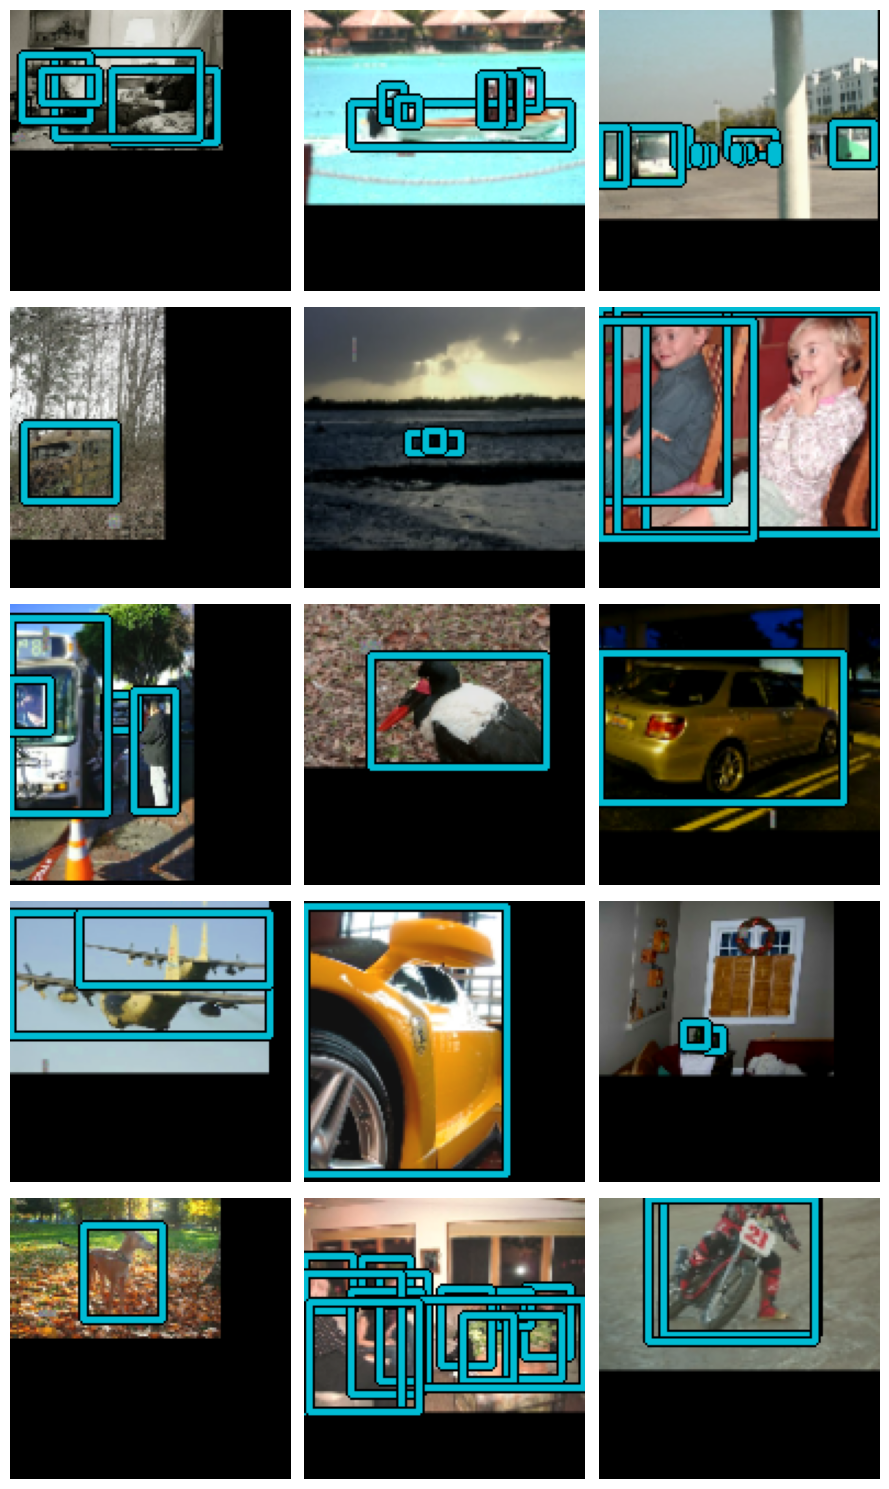

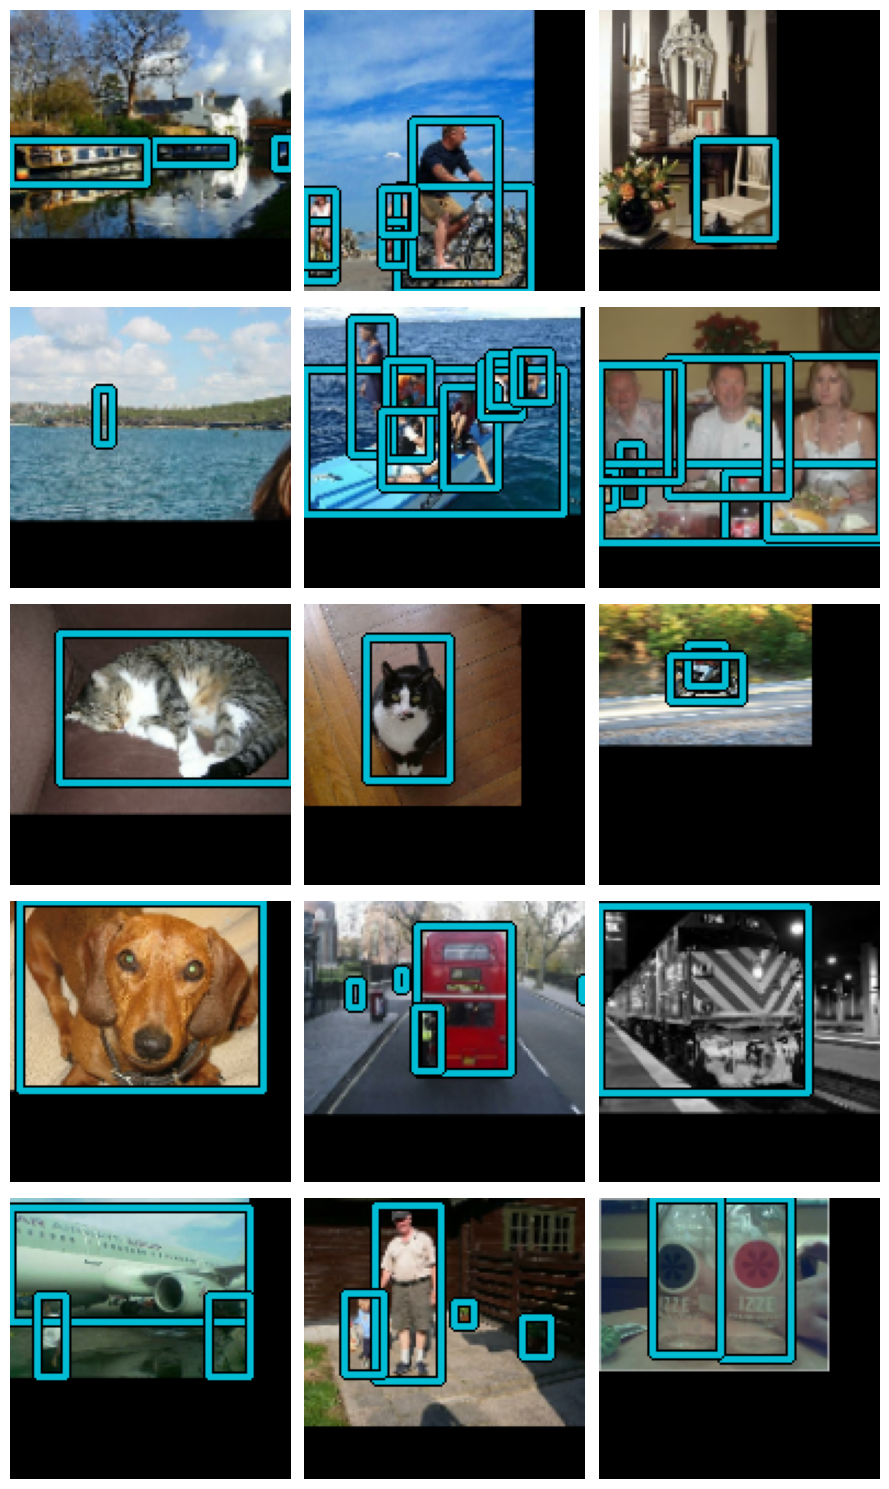

In [4]:
img_path = r'../Data/voc2007/all/images'
label_path= r'../Data/voc2007/all/annotations'
#train_ds, val_ds, test_ds = build_img_dataset_pipeline(img_path, label_path, n_classes=20, img_size=(416, 416, 3), batch_size=16,img_type='jpeg', label_format='pascal_voc', return_filenames=False)
train_ds, val_ds = build_image_detection_pipeline(img_path=img_path, labels_path=label_path, annotation_format="pascal_voc",img_size=(128, 128), batch_size=16)
#keras_cv.visualization.plot_image_gallery(train_ds, scale=3,value_range=(0,1))

In [5]:
def get_backbone(type, weights, model_size):
    hub_presets = {
        ('retinanet', 'coco'): "retinanet_resnet50_fpn_v2_coco",
        ('retinanet', 'voc'): "retinanet_resnet50_pascalvoc",
        ('faster_rcnn', 'coco'): "faster_rcnn_resnet50_fpn_coco",
        ('faster_rcnn', 'voc'): "faster_rcnn_resnet50_pascalvoc"
    }
    if (type, weights) in hub_presets:
        preset = hub_presets[(type, weights)]
    resnet_size_map = {
    's': '50',    # Small = ResNet-50
    'm': '101',   # Medium = ResNet-101
    'l': '152',   # Large = ResNet-152
    'xl': '152'   # Extra Large = ResNet-152 (fallback to largest available)
    }
    
    # Map model_size to EfficientNetV1 variant
    efficientnetv1_size_map = {
        's': '0',  # Small = B0
        'm': '1',  # Medium = B1
        'l': '2',  # Large = B2
        'xl': '3'  # Extra Large = B3
    }
    
    # Backbone initialization functions - using lambdas for lazy initialization
    backbone_factories = {
        # ResNet V2 family - using size parameter
        'resnetv2': {
            'imagenet': keras_cv.models.ResNet50V2Backbone.from_preset("resnet50_v2_imagenet"),
            None: {
                'xs': keras_cv.models.ResNet50V2Backbone.from_preset("resnet18_v2"),
                's': keras_cv.models.ResNet50V2Backbone.from_preset("resnet34_v2"),
                'm': keras_cv.models.ResNet50V2Backbone.from_preset("resnet50_v2"),
                'l': keras_cv.models.ResNet50V2Backbone.from_preset("resnet101_v2"),
            } 
        },
        # CSP DarkNet
        'cspdarknet': {
            'imagenet': {
                's': keras_cv.models.CSPDarkNetBackbone.from_preset("csp_darknet_tiny_imagenet"),
                'l': keras_cv.models.CSPDarkNetBackbone.from_preset("csp_darknet_l_imagenet")
                },
            None: {
                's': keras_cv.models.CSPDarkNetBackbone.from_preset("csp_darknet_tiny"),
                'm': keras_cv.models.CSPDarkNetBackbone.from_preset("csp_darknet_s"),
                'l': keras_cv.models.CSPDarkNetBackbone.from_preset("csp_darknet_m"),
                'xl': keras_cv.models.CSPDarkNetBackbone.from_preset("csp_darknet_l")
                }
        },
        
        'efficientnet': {
            None: {
                's': keras_cv.models.EfficientNetV2Backbone.from_preset(f"efficientnetv2_b0"),
                'm': keras_cv.models.EfficientNetV2Backbone.from_preset(f"efficientnetv2_b1"),
                'l': keras_cv.models.EfficientNetV2Backbone.from_preset(f"efficientnetv2_b2"),
                'xl': keras_cv.models.EfficientNetV2Backbone.from_preset(f"efficientnetv2_b3")
                },
            'imagenet': {
                's': keras_cv.models.EfficientNetV2Backbone.from_preset(f"efficientnetv2_b0_imagenet"),
                'm': keras_cv.models.EfficientNetV2Backbone.from_preset(f"efficientnetv2_b1_imagenet"),
                'l': keras_cv.models.EfficientNetV2Backbone.from_preset(f"efficientnetv2_b2_imagenet"),
                },
        },
        'efficientnetlite': {
            None: {
                's': keras_cv.models.EfficientNetLiteBackbone.from_preset(f"efficientnetlite_b0"),
                'm': keras_cv.models.EfficientNetLiteBackbone.from_preset(f"efficientnetlite_b1"),
                'l': keras_cv.models.EfficientNetLiteBackbone.from_preset(f"efficientnetlite_b2"),
                'xl': keras_cv.models.EfficientNetLiteBackbone.from_preset(f"efficientnetlite_b3")
                }
        },
        
        # MobileNet
        'mobilenet': {
            None: {
                's': keras_cv.models.EfficientNetV2Backbone.from_preset(f"mobilenet_v3_small"),
                'l': keras_cv.models.EfficientNetV2Backbone.from_preset(f"mobilenet_v3_large"),
                },
            'imagenet': {
                's': keras_cv.models.EfficientNetV2Backbone.from_preset(f"mobilenet_v3_small_imagenet"),
                'l': keras_cv.models.EfficientNetV2Backbone.from_preset(f"mobilenet_v3_large_imagenet"),
            },
        },
        
        # YOLO v8 specific backbones
        'yolov8': {
            'coco':{
                's': keras_cv.models.YOLOV8Backbone.from_preset(f"yolo_v8_xs_backbone_coco"),
                'm': keras_cv.models.YOLOV8Backbone.from_preset(f"yolo_v8_s_backbone_coco"),
                'l': keras_cv.models.YOLOV8Backbone.from_preset(f"yolo_v8_m_backbone_coco"),
                },
            'voc': keras_cv.models.YOLOV8Backbone.from_preset(f"yolo_v8_m_pascalvoc"),
            None:{ 
                's': keras_cv.models.YOLOV8Backbone.from_preset(f"yolo_v8_xs_backbone"),
                'm': keras_cv.models.YOLOV8Backbone.from_preset(f"yolo_v8_s_backbone"),
                'l': keras_cv.models.YOLOV8Backbone.from_preset(f"yolo_v8_m_backbone"),
                }
        }
    }
    

def build_detection_model(n_classes, lr=0.001, model_name='ssd',weights='coco',model_size='s',backbone='standard'):
    '''
    This function builds a model for object detection using Keras CV.
    
    Parameters:
    input_shape: tuple, shape of the input images; should be in the format (height, width, channels)
    n_classes: int, number of object classes to detect (excluding background class)
    model_name: str (optional, default: 'ssd'), name of the detection model
                Options: 'ssd', 'retinanet', 'faster_rcnn', 'yolov8'
    
    Returns:
    model: keras.Model, the model for object detection
    '''
    
    assert model_name in ['ssd', 'retinanet', 'faster_rcnn', 'yolov8'], f"Model {model_name} not supported"
    assert weights in ['coco', 'imagenet','voc', None], f"Weights {weights} not supported"
    assert model_size in ['s', 'm', 'l', 'xl'], f"Model size {model_size} not supported"
    
    # if model_name == 'ssd':
    #     model = detection.SSD(input_shape, num_classes=n_classes)
    if model_name == 'retinanet':
        if backbone == 'standard':
            if weights == 'coco':
                model =  keras_hub.models.ImageObjectDetector.from_preset("retinanet_resnet50_fpn_v2_coco", num_classes=n_classes, bounding_box_format="xyxy")
            elif weights == 'voc':
                model =  keras_hub.models.ImageObjectDetector.from_preset("retinanet_resnet50_pascalvoc", num_classes=n_classes, bounding_box_format="xyxy")
            elif weights == 'imagenet':
                model = keras_cv.models.RetinaNet(num_classes=n_classes, bounding_box_format="xyxy",
                                                backbone=keras_cv.models.ResNet50Backbone.from_preset("resnet50_v2_imagenet"),)   
            elif weights == None:
                model = keras_cv.models.RetinaNet(num_classes=n_classes, bounding_box_format="xyxy",
                                                backbone=keras_cv.models.ResNet50V2Backbone(),)   
        else:
            backbone = get_backbone(backbone, weights, model_size)
            model = keras_cv.models.RetinaNet(num_classes=n_classes, bounding_box_format="xyxy", backbone=backbone)
            
    elif model_name == 'faster_rcnn':
        if backbone == 'standard':
            if weights == 'coco':
                model =  keras_hub.models.ImageObjectDetector.from_preset("faster_rcnn_resnet50_fpn_coco", num_classes=n_classes, bounding_box_format="xyxy")
            elif weights == 'voc':
                model =  keras_hub.models.ImageObjectDetector.from_preset("faster_rcnn_resnet50_pascalvoc", num_classes=n_classes, bounding_box_format="xyxy")
            elif weights == 'imagenet':
                model = keras_cv.models.FasterRCNN(num_classes=n_classes, bounding_box_format="xyxy",
                                                backbone=keras_cv.models.ResNet50Backbone.from_preset("resnet50_v2_imagenet"),)   
            elif weights == None:
                model = keras_cv.models.FasterRCNN(num_classes=n_classes, bounding_box_format="xyxy",
                                                backbone=keras_cv.models.ResNet50V2Backbone(),)   
        else:
            backbone = get_backbone(backbone, weights, model_size)
            model = keras_cv.models.FasterRCNN(num_classes=n_classes, bounding_box_format="xyxy", backbone=backbone)
        
    elif model_name == 'yolov8':
        if backbone == 'standard':
            if weights == 'coco':
                model = keras_cv.models.YOLOV8Detector(num_classes=n_classes, bounding_box_format="xyxy", backbone=keras_cv.models.YOLOV8Backbone.from_preset(f"yolo_v8_{model_size}_backbone_coco"),)
            if weights == 'voc':
                model = keras_cv.models.YOLOV8Detector(num_classes=n_classes, bounding_box_format="xyxy",  backbone=keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_m_pascalvoc",))
            #raise ValueError("VOC weights not supported for YOLOV8")
            if weights == 'imagenet':
                model = keras_cv.models.YOLOV8Detector(num_classes=n_classes, bounding_box_format="xyxy",  backbone=keras_cv.models.ResNet50Backbone.from_preset("resnet50_v2_imagenet"),)
            if weights == None:
                model = keras_cv.models.YOLOV8Detector(num_classes=n_classes, bounding_box_format="xyxy",  backbone=keras_cv.models.YOLOV8Backbone.from_preset(f"yolo_v8_{model_size}_backbone"),)
        elif backbone == 'resnet':
            if weights == 'coco':
                model = keras_cv.models.YOLOV8Detector(num_classes=n_classes, bounding_box_format="xyxy", backbone=keras_cv.models.ResNet50Backbone.from_preset("resnet50_v2_coco"),)
            if weights == 'voc':
                model = keras_cv.models.YOLOV8Detector(num_classes=n_classes, bounding_box_format="xyxy", backbone=keras_cv.models.ResNet50Backbone.from_preset("resnet50_v2_pascalvoc"),)
            if weights == 'imagenet':
                model = keras_cv.models.YOLOV8Detector(num_classes=n_classes, bounding_box_format="xyxy", backbone=keras_cv.models.ResNet50Backbone.from_preset("resnet50_v2_imagenet"),)
            if weights == None:
                model = keras_cv.models.YOLOV8Detector(num_classes=n_classes, bounding_box_format="xyxy", backbone=keras_cv.models.ResNet50Backbone(),)    
        else:
            backbone = get_backbone(backbone, weights, model_size)
            model = keras_cv.models.YOLOV8Detector(num_classes=n_classes, bounding_box_format="xyxy", backbone=backbone)
            
    
    return model    

def compile_model(model, optimizer='adam', lr=0.001,verbose=0):
    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    elif optimizer == 'lamb':
        optimizer = keras.optimizers.LAMB(learning_rate=lr)  
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, box_loss="ciou",classification_loss='binary_crossentropy')
    
    if verbose:
        model.summary()

    return model

In [11]:
def train_detection_model(model, train_ds, val_ds, epochs=10, verbose=1,folder='projects'):
    '''
    This function trains a model for object detection using Keras CV.
    
    Parameters:
    model: keras.Model, the model for object detection
    train_ds: tf.data.Dataset, the training dataset
    val_ds: tf.data.Dataset, the validation dataset
    epochs: int, number of epochs for training
    verbose: int, whether to print training information
    
    Returns:
    history: dict, history of training metrics
    '''
    save_path = r'../Data/trained_models'
    model_name = model.name
    if 'yolov8' in model_name:
        model_name = 'yolov8'
    datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    savedir = os.path.join(save_path, folder, datetime_str, model_name)
    print('savedir:',savedir)
    if not os.path.exists(savedir):
        os.makedirs(savedir, exist_ok=True)
        
    checkpoints = os.path.join(savedir, 'best_weights')
    if not os.path.exists(checkpoints):
        os.makedirs(checkpoints, exist_ok=True)
    # Train the model
    
    callbacks = []
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoints+'/checkpoint.weights.h5'),save_best_only=True,save_weights_only=True,monitor='val_loss',mode='min',verbose=1))
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True))
    callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_delta=0.001, cooldown=0, min_lr=0))
    callbacks.append(keras_cv.callbacks.PyCOCOCallback(val_ds, bounding_box_format="xyxy"))
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose,callbacks=callbacks)
    #load best weights
    model.load_weights(os.path.join(checkpoints+'/checkpoint.weights.h5'))
    # Save the model
    model.save(os.path.join(savedir, 'model.keras'))
    
    
    return history, model

100%|██████████| 9963/9963 [00:00<00:00, 20181.34it/s]


class_mapping: {'dog': 0, 'person': 1, 'train': 2, 'sofa': 3, 'chair': 4, 'car': 5, 'pottedplant': 6, 'diningtable': 7, 'horse': 8, 'cat': 9, 'cow': 10, 'bus': 11, 'bicycle': 12, 'aeroplane': 13, 'motorbike': 14, 'tvmonitor': 15, 'bird': 16, 'bottle': 17, 'boat': 18, 'sheep': 19}
bbs: <tf.RaggedTensor [[[48.0, 240.0, 195.0, 371.0],
  [8.0, 12.0, 352.0, 498.0]]  , [[139.0, 200.0, 207.0, 301.0]],
 [[123.0, 155.0, 215.0, 195.0],
  [239.0, 156.0, 307.0, 205.0]], [[13.0, 311.0, 84.0, 362.0],
                                  [362.0, 330.0, 500.0, 389.0],
                                  [235.0, 328.0, 334.0, 375.0],
                                  [175.0, 327.0, 252.0, 364.0],
                                  [139.0, 320.0, 189.0, 359.0],
                                  [108.0, 325.0, 150.0, 353.0],
                                  [84.0, 323.0, 121.0, 350.0]] ,
 [[263.0, 211.0, 324.0, 339.0],
  [165.0, 264.0, 252.0, 372.0],
  [5.0, 244.0, 67.0, 374.0],
  [241.0, 194.0, 295.0, 299.0]

2025-03-19 16:46:39.753282: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


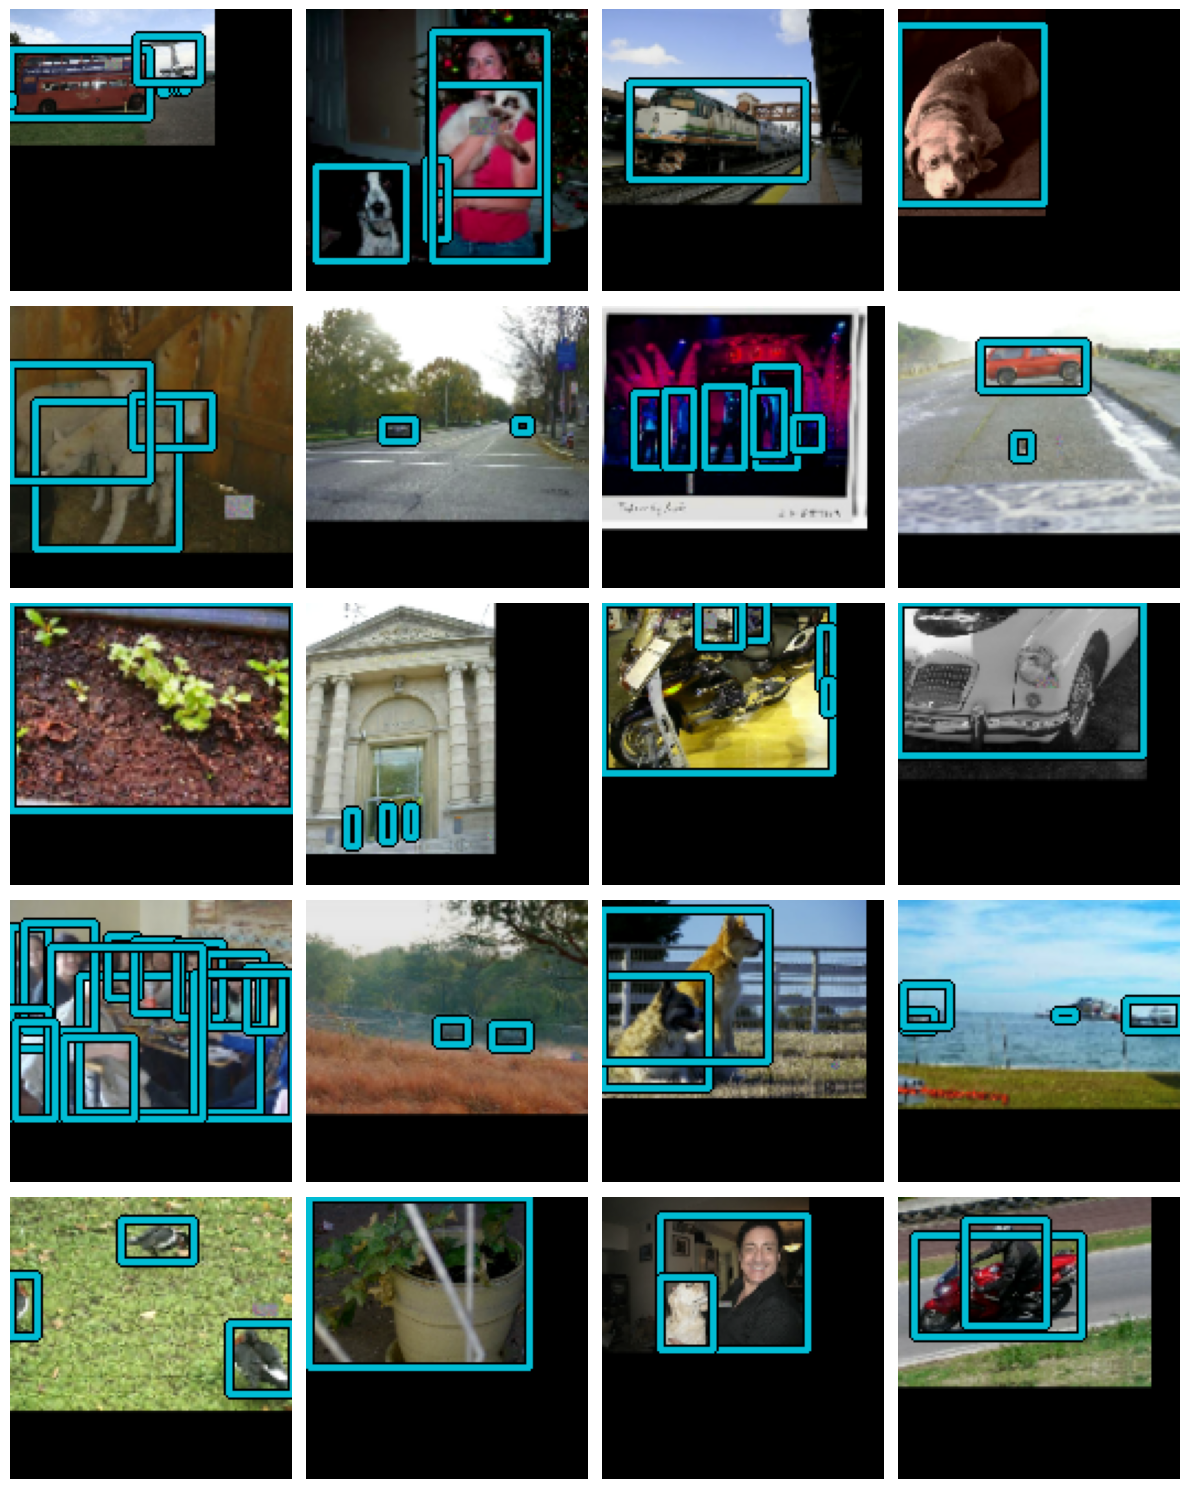

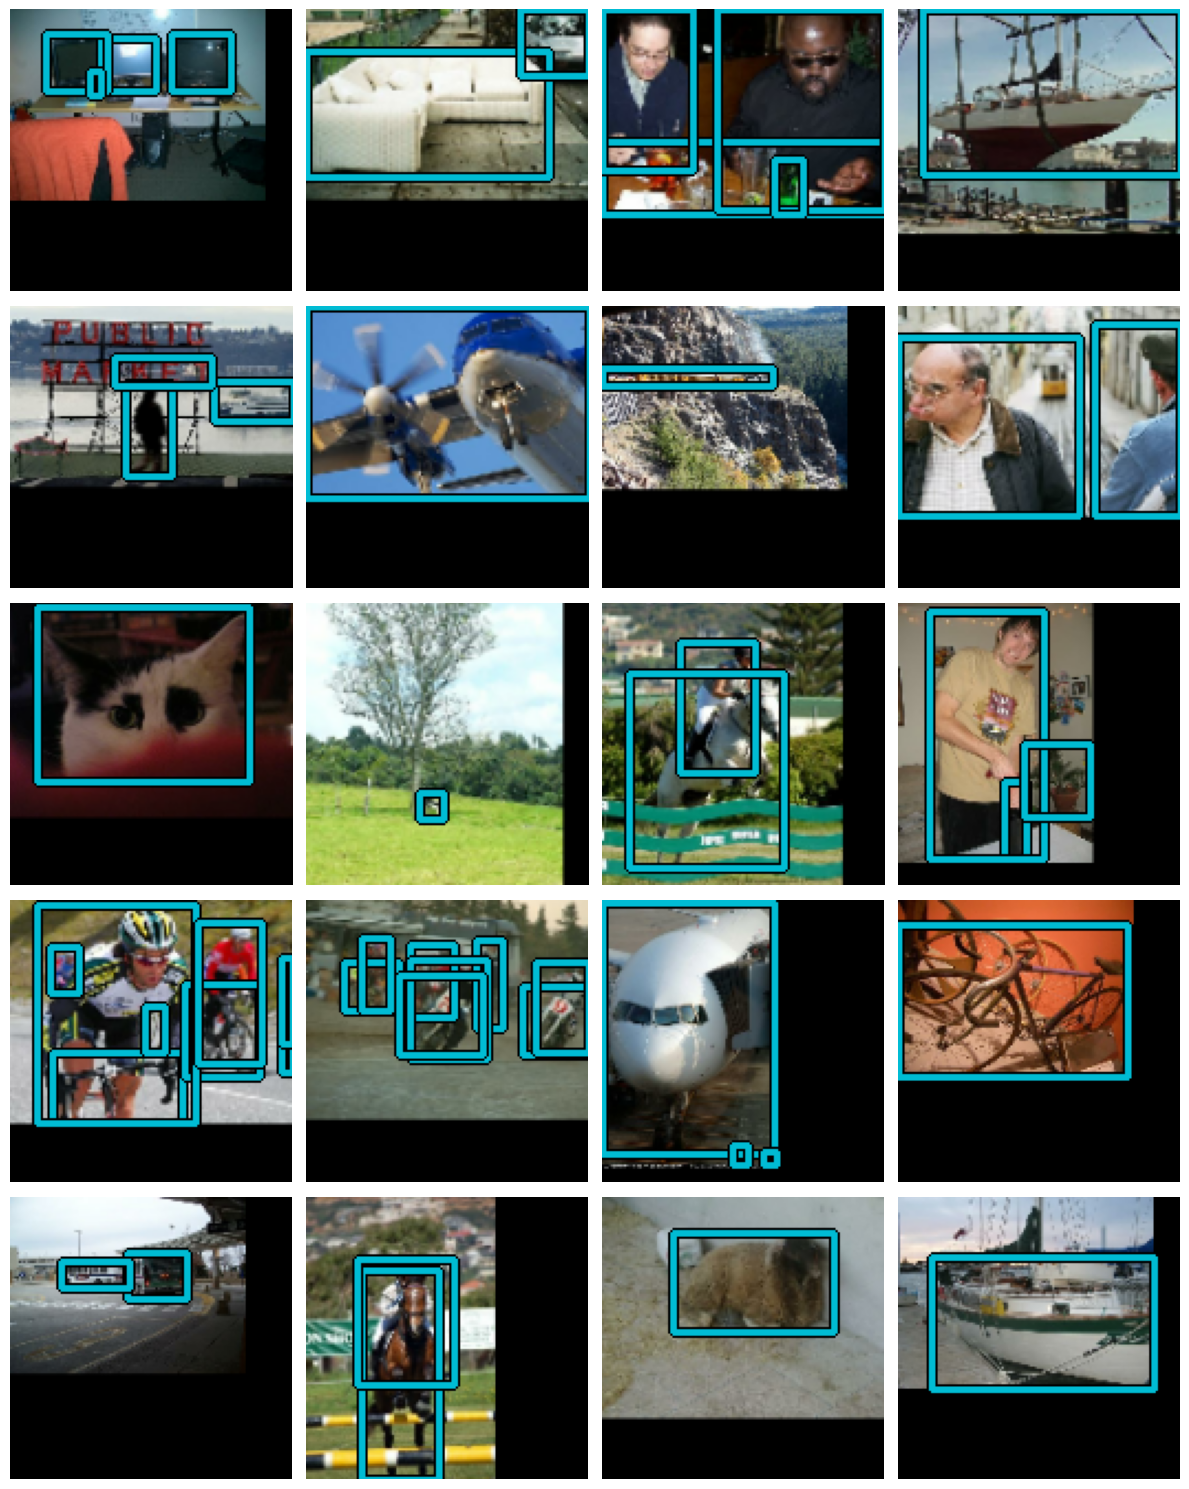

savedir: ../Data/trained_models/test/20250319-164642/yolov8
Epoch 1/5


/home/ue/miniconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_901']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - box_loss: 3.0611 - class_loss: 15.8715 - loss: 18.9327
Epoch 1: val_loss improved from inf to 3.38443, saving model to ../Data/trained_models/test/20250319-164642/yolov8/best_weights/checkpoint.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0

In [12]:
img_path = r'../Data/voc2007/all/images'
label_path= r'../Data/voc2007/all/annotations'
train_ds, val_ds = build_image_detection_pipeline(img_path=img_path, labels_path=label_path, annotation_format="pascal_voc",img_size=(128,128), batch_size=32)

model = build_detection_model(n_classes=20, model_name='yolov8',weights='coco',model_size='s',backbone='standard')
model = compile_model(model, optimizer='adam', lr=0.001)
history, model = train_detection_model(model, train_ds, val_ds, epochs=5, verbose=1, folder='test')

In [20]:
def evaluate_object_detection_model(model, dataset, box_format='xyxy', verbose=1):
    """
    Evaluates the performance of an object detection model using keras_cv's BoxCOCOMetrics.
    
    Args:
        model: A Keras object detection model
        dataset: A tf.data.Dataset with images and ground truth bounding boxes
        box_format: Format of input boxes (default: 'xyxy')
        verbose: Verbosity level (0: silent, 1: progress bar)
        
    Returns:
        Dictionary containing evaluation metrics
    """
    import tensorflow as tf
    import keras_cv
    from tqdm import tqdm
    
    # Initialize metrics suite
    metrics_suite = keras_cv.src.metrics.BoxCOCOMetrics(bounding_box_format=box_format,evaluate_freq=1)
    
    # Process each batch in the dataset
    for batch in tqdm(dataset, desc="Evaluating", disable=not verbose):
        # Extract images from the batch
        if isinstance(batch, tuple) and len(batch) == 2:
            images, y_true = batch
        else:
            # Extract images from dictionary
            images = batch.get('images', batch.get('image', batch))
            y_true = batch
        
        # Run model prediction
        y_pred = model.predict(images, verbose=0)
        
        # Ensure data is in the right format
        if not isinstance(y_true, dict):
            # Convert tuple format (boxes, classes) to dictionary
            boxes = y_true[0]
            classes = y_true[1] if len(y_true) > 1 else tf.zeros_like(boxes[..., 0], dtype=tf.int32)
            y_true = {'boxes': boxes, 'classes': classes}
            
        if not isinstance(y_pred, dict):
            # Convert tuple format (boxes, scores, classes) to dictionary
            boxes = y_pred[0]
            scores = y_pred[1] if len(y_pred) > 1 else tf.ones_like(boxes[..., 0], dtype=tf.float32)
            classes = y_pred[2] if len(y_pred) > 2 else tf.zeros_like(boxes[..., 0], dtype=tf.int32)
            y_pred = {'boxes': boxes, 'confidence': scores, 'classes': classes}
        
        # Convert boxes to required 'yxyx' format
        y_true['boxes'] = keras_cv.bounding_box.convert_format(
            y_true['boxes'], source=box_format, target='yxyx', images=images
        )
        y_pred['boxes'] = keras_cv.bounding_box.convert_format(
            y_pred['boxes'], source=box_format, target='yxyx', images=images
        )
        
        # Update metrics
        metrics_suite.update_state(y_true, y_pred)
    
    # Get results
    return metrics_suite.result()

In [ ]:
result = evaluate_object_detection_model(model, val_ds)

Evaluating:  60%|██████    | 56/93 [01:10<01:24,  2.27s/it]